First, we import all the necessary libraries.

In [107]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os

from datetime import datetime
from sklearn.utils import shuffle

Our basic helper functions will give us the error rate and the indicator matrix for our predictions.

In [108]:
def y2indicator(y):
    N = len(y)
    y = y.astype(np.int32)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

def error_rate(p, t):
    return np.mean(p != t)

Next, we load the data, normalize it, reshape it, and generate our train and test datasets.

In [109]:
data = pd.read_csv(os.path.join('data', 'train.csv'))

In [110]:
def get_normalized_data(data):
    data = data.as_matrix().astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std == 0, 1)
    X = (X - mu) / std
    Y = data[:, 0]
    return X, Y

In [111]:
X, Y = get_normalized_data(data)

In [112]:
X = X.reshape(len(X), 28, 28, 1)

In [113]:
X = X.astype(np.float32)

In [114]:
Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest  = X[-1000:,]
Ytest  = Y[-1000:]
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

In our convpool function, we will take a stride of one, and we will ensure that the dimensions of output of the convolution are the same as the input by setting _padding_ to 'SAME.' Our downnsampling will be of size two, and we will apply the ReLu activation function on the output.

In [115]:
def convpool(X, W, b):
    # just assume pool size is (2,2) because we need to augment it with 1s
    # - stride is the interval at which to apply the convolution
    conv_out = tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out, b)
    pool_out = tf.nn.max_pool(conv_out, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return tf.nn.relu(pool_out)

The way we always initialize weights is random normal / sqrt(fan in + fan out). The key point is it's random with a variance restricted by the size.

In [116]:
def init_filter(shape, poolsz):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
    return w.astype(np.float32)

We define our gradient descent parameters, which include the number of iterations, batch size, number of hidden layers, number of classes, and the pool size.

In [117]:
# gradient descent params
max_iter = 6
print_period = 10
N = Xtrain.shape[0]
batch_sz = 500
n_batches = N / batch_sz

# limit samples since input will always have to be same size
# you could also just do N = N / batch_sz * batch_sz

M = 500
K = 10
poolsz = (2, 2)

When initializing our filters, we have to remember that TensorFlow has its own ordering of dimensions. The output after convpooling is going to be 7x7, which is different from Theano.

In [118]:
W1_shape = (5, 5, 1, 20) # (filter_width, filter_height, num_color_channels, num_feature_maps)
W1_init = init_filter(W1_shape, poolsz)
b1_init = np.zeros(W1_shape[-1], dtype=np.float32) # one bias per output feature map

W2_shape = (5, 5, 20, 50) # (filter_width, filter_height, old_num_feature_maps, num_feature_maps)
W2_init = init_filter(W2_shape, poolsz)
b2_init = np.zeros(W2_shape[-1], dtype=np.float32)

W3_init = np.random.randn(W2_shape[-1]*7*7, M) / np.sqrt(W2_shape[-1]*7*7 + M)
b3_init = np.zeros(M, dtype=np.float32)
W4_init = np.random.randn(M, K) / np.sqrt(M + K)
b4_init = np.zeros(K, dtype=np.float32)

Next, we define our input and target placeholders, as well as the variables which will be updated during the training process. 

In [119]:
# using None as the first shape element takes up too much RAM unfortunately
X = tf.placeholder(tf.float32, shape=(batch_sz, 28, 28, 1), name='X')
T = tf.placeholder(tf.float32, shape=(batch_sz, K), name='T')
W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))
W4 = tf.Variable(W4_init.astype(np.float32))
b4 = tf.Variable(b4_init.astype(np.float32))

This is our feedforward mechanism. Note that flattening the output of our second convpool layer requires an extra step when using TensorFlow. We will also apply RMSProp during training in order to accelerate our process of gradient descent.

In [120]:
Z1 = convpool(X, W1, b1)
Z2 = convpool(Z1, W2, b2)
Z2_shape = Z2.get_shape().as_list()
Z2r = tf.reshape(Z2, [Z2_shape[0], np.prod(Z2_shape[1:])])
Z3 = tf.nn.relu( tf.matmul(Z2r, W3) + b3 )
Yish = tf.matmul(Z3, W4) + b4

cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits = Yish, labels = T))

train_op = tf.train.RMSPropOptimizer(0.0001, decay=0.99, momentum=0.9).minimize(cost)

# we'll use this to calculate the error rate
predict_op = tf.argmax(Yish, 1)

Our training process is standard, except that when making predictions against the test set, due to RAM limitations we need to have a fixed size input; so as a result, we have have to add a slightly complex total cost and prediction computation.

In [121]:
test = pd.read_csv(os.path.join('data', 'test.csv'))

In [122]:
test = test.as_matrix().astype(np.float32)

In [123]:
data = data.as_matrix().astype(np.float32)

In [124]:
mean = data.mean(axis=0)[1:]
std = data.std(axis = 0)[1:]

In [125]:
np.place(std, std == 0, 1)

In [126]:
test = (test - mean)/std

In [127]:
test = test.reshape(len(test), 28, 28, 1)

In [128]:
test = test.astype(np.float32)

Cost / err at iteration i=0, j=0: 2126.348 / 0.669
Cost / err at iteration i=1, j=0: 128.325 / 0.036
Cost / err at iteration i=2, j=0: 76.625 / 0.023
Cost / err at iteration i=3, j=0: 72.436 / 0.023
Cost / err at iteration i=4, j=0: 76.117 / 0.023
Cost / err at iteration i=5, j=0: 53.872 / 0.020
Elapsed time: 0:09:06.801404


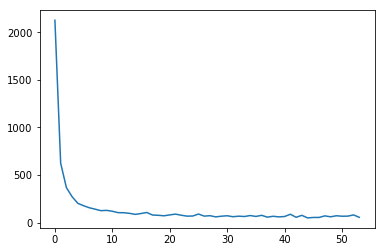

In [129]:
t0 = datetime.now()
LL = []
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)

    for i in range(int(max_iter)):
        for j in range(int(n_batches)):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

            if len(Xbatch) == batch_sz:
                session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
                if j % print_period == 0:
                    test_cost = 0
                    prediction = np.zeros(len(Xtest))
                    for k in range(int(len(Xtest) / batch_sz)):
                        Xtestbatch = Xtest[k*batch_sz:(k*batch_sz + batch_sz),]
                        Ytestbatch = Ytest_ind[k*batch_sz:(k*batch_sz + batch_sz),]
                        test_cost += session.run(cost, feed_dict={X: Xtestbatch, T: Ytestbatch})
                        prediction[k*batch_sz:(k*batch_sz + batch_sz)] = session.run(
                            predict_op, feed_dict={X: Xtestbatch})
                    err = error_rate(prediction, Ytest)
                    if j == 0:
                        print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                    LL.append(test_cost)
    prediction = np.zeros(len(test))
    for k in range(int(len(test) / batch_sz)):
        Xtestbatch = test[k*batch_sz:(k*batch_sz + batch_sz),]
        prediction[k*batch_sz:(k*batch_sz + batch_sz)] = session.run(predict_op, feed_dict={X: Xtestbatch})
print("Elapsed time:", (datetime.now() - t0))
plt.plot(LL)
plt.show()

In [135]:
ImageId = np.linspace(1, 28000, 28000)

In [136]:
y_test = pd.DataFrame(np.vstack((ImageId, prediction)).transpose().astype(np.int))

In [137]:
y_test.columns = ['ImageId', 'Label']

In [138]:
y_test.to_csv(os.path.join('submission_files', 'y_test3.csv'), index = False)

In [140]:
y_test['Label'].value_counts(normalize=True)

1    0.115679
8    0.101679
7    0.101679
2    0.101143
3    0.100714
6    0.099214
4    0.098786
0    0.098286
9    0.095143
5    0.087679
Name: Label, dtype: float64